In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 1: Images Count**

In [ ]:
# Quick counts (run interactively)
from glob import glob
import os
BASE = '/content/drive/MyDrive/Colab Notebooks/Dataset/CAMO'
print("train images:", len(glob(os.path.join(BASE,'images/train','*.*'))))
print("val images:",  len(glob(os.path.join(BASE,'images/val','*.*'))))
print("GT masks:",      len(glob(os.path.join(BASE,'GT','*.*'))))

train images: 1000
val images: 250
GT masks: 1250


**Step 2.1 Convert Masks to YOLO Labels**

In [ ]:
import os
from glob import glob
from PIL import Image
import cv2

# === CONFIG ===
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Dataset/CAMO'
IMAGE_DIRS = {
    'train': os.path.join(BASE_PATH, 'images/train'),
    'val':  os.path.join(BASE_PATH, 'images/val'),
}
GT_MASK_DIR = os.path.join(BASE_PATH, 'GT')
LABEL_DIRS = {
    'train': os.path.join(BASE_PATH, 'labels/train'),
    'val':  os.path.join(BASE_PATH, 'labels/val'),
}
os.makedirs(LABEL_DIRS['train'], exist_ok=True)
os.makedirs(LABEL_DIRS['val'], exist_ok=True)

# file extensions to search for
IMAGE_EXTS = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

# === helpers ===
def find_mask_file(gt_dir, stem):
    # try common extensions first
    for ext in ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff']:
        p = os.path.join(gt_dir, stem + ext)
        if os.path.exists(p):
            return p
    # fallback to any file that starts with the stem
    matches = glob(os.path.join(gt_dir, stem + '.*'))
    return matches[0] if matches else None

def mask_to_yolo(mask_path, image_size, min_area=20, approx_eps=0.01):
    """
    mask_path: path to mask (grayscale or RGB)
    image_size: (width, height) of the corresponding image
    returns: list of annotation lines (one per polygon), each line like:
             "0 x1 y1 x2 y2 x3 y3 ..."  (normalized coordinates 0..1)
    """
    img_w, img_h = image_size
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"[!] Failed to read mask: {mask_path}")
        return []

    # binarize
    _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # resize if mask and image differ
    if (mask_bin.shape[1], mask_bin.shape[0]) != (img_w, img_h):
        mask_bin = cv2.resize(mask_bin, (img_w, img_h), interpolation=cv2.INTER_NEAREST)

    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    annotations = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        peri = cv2.arcLength(cnt, True)
        epsilon = approx_eps * peri
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        pts = approx.reshape(-1, 2)
        if pts.shape[0] < 3:
            continue
        flat = []
        for x, y in pts:
            # normalize and clamp
            xn = min(max(float(x) / img_w, 0.0), 1.0)
            yn = min(max(float(y) / img_h, 0.0), 1.0)
            flat.extend([xn, yn])
        line = "0 " + " ".join(f"{v:.6f}" for v in flat)
        annotations.append(line)
    return annotations

def process_split(image_dir, label_dir):
    image_files = []
    for ext in IMAGE_EXTS:
        image_files += glob(os.path.join(image_dir, f"*{ext}"))
    image_files = sorted(image_files)

    processed = 0
    missing_mask = 0
    empty_mask = 0

    for img_path in image_files:
        stem = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = find_mask_file(GT_MASK_DIR, stem)
        if mask_path is None:
            print(f"[!] Missing mask for {stem}")
            missing_mask += 1
            continue

        with Image.open(img_path) as im:
            w, h = im.size  # PIL: (width, height)

        annots = mask_to_yolo(mask_path, (w, h))
        out_path = os.path.join(label_dir, stem + '.txt')
        with open(out_path, 'w') as f:
            if not annots:
                # write empty file (no objects)
                empty_mask += 1
            for line in annots:
                f.write(line + '\n')
        processed += 1

    print(f"[done] {label_dir} -> processed: {processed}, missing masks: {missing_mask}, empty masks: {empty_mask}")

# === run ===
process_split(IMAGE_DIRS['train'], LABEL_DIRS['train'])
process_split(IMAGE_DIRS['val'],  LABEL_DIRS['val'])

[done] /content/drive/MyDrive/Colab Notebooks/Dataset/CAMO/labels/train -> processed: 1000, missing masks: 0, empty masks: 0
[done] /content/drive/MyDrive/Colab Notebooks/Dataset/CAMO/labels/val -> processed: 250, missing masks: 0, empty masks: 0


**Step 3: Verify Label File Creation**

In [ ]:
from glob import glob
import os

img_train = glob('/content/drive/MyDrive/Colab Notebooks/Dataset/CAMO/images/train/*')
lbl_train = glob('/content/drive/MyDrive/Colab Notebooks/Dataset/CAMO/labels/train/*')

print("Train images:", len(img_train))
print("Train labels:", len(lbl_train))

Train images: 1000
Train labels: 1000


**Step 4 — Quick validation & visualization (sanity checks)**

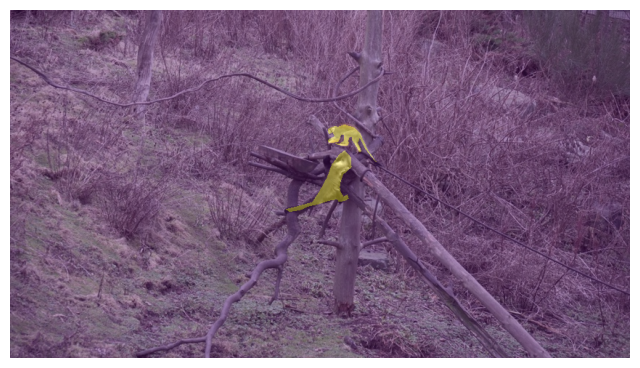

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

def vis(img_path, mask_path):
    if not os.path.exists(img_path):
        print(f"Error: Image file not found at {img_path}")
        return
    if not os.path.exists(mask_path):
        print(f"Error: Mask file not found at {mask_path}")
        return

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, mask_b = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.imshow(mask_b, alpha=0.4)
    plt.axis('off')
    plt.show()

# Example:
vis(IMAGE_DIRS['train'] + '/camourflage_00401.jpg', GT_MASK_DIR + '/camourflage_00401.png')

**Step 5: Create Data Configuration File**

In [ ]:
data_yaml = """
train: /content/drive/MyDrive/Colab Notebooks/Dataset/CAMO/images/train
val: /content/drive/MyDrive/Colab Notebooks/Dataset/CAMO/images/val

nc: 1
names: ['camouflaged']
"""

with open('/content/camo.yaml', 'w') as f:
    f.write(data_yaml)

print(" data.yaml created at /content/camo.yaml")

 data.yaml created at /content/camo.yaml


**Step 6: Install Dependencies**

In [ ]:
%pip install ultralytics

**Step 7: Test YOLOv8 Dataset Setup**

In [ ]:
!yolo val data=/content/camo.yaml model=yolov8n-seg.pt

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,404,320 parameters, 0 gradients, 12.6 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 89.0±79.0 MB/s, size: 188.4 KB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/Dataset/CAMO/labels/val.cache... 250 images, 0 backgrounds, 0 corrupt: 100% 250/250 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0% 0/16 [00:00<?, ?it/s]WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to firs

**Step 8: Train YOLOv8 Segmentation Model**

In [ ]:
!yolo segment train data=/content/camo.yaml model=yolov8n-seg.pt epochs=100 imgsz=640 batch=8 name=train_epochs_100

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/camo.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_epochs_100, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

**Step 9: Train YOLOv8 Detection Model**

In [ ]:
!yolo detect train data=/content/camo.yaml model=yolov8n.pt epochs=100 imgsz=640 batch=16

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/camo.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, p

**Step 10: Evaluate Model Performance**

In [ ]:
# Evaluate the trained segmentation model
!yolo val data=/content/camo.yaml model=runs/segment/train_epochs_100/weights/best.pt

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 147.0±147.9 MB/s, size: 219.3 KB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/Dataset/CAMO/labels/val.cache... 250 images, 0 backgrounds, 0 corrupt: 100% 250/250 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0% 0/16 [00:00<?, ?it/s]WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   6% 1/16 [00:00<00:05,  2.53it/s]WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
                 Class     Ima

**Step 11: Run Inference on New Data**

In [ ]:
# Run inference on an example image
!yolo predict model=runs/segment/train_epochs_100/weights/best.pt source=/content/drive/MyDrive/Colab\ Notebooks/Dataset/CAMO/images/train/camourflage_00401.jpg

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs

image 1/1 /content/drive/MyDrive/Colab Notebooks/Dataset/CAMO/images/train/camourflage_00401.jpg: 384x640 5 camouflageds, 50.7ms
Speed: 3.6ms preprocess, 50.7ms inference, 160.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


**Step 12: Visualize Inference Results**

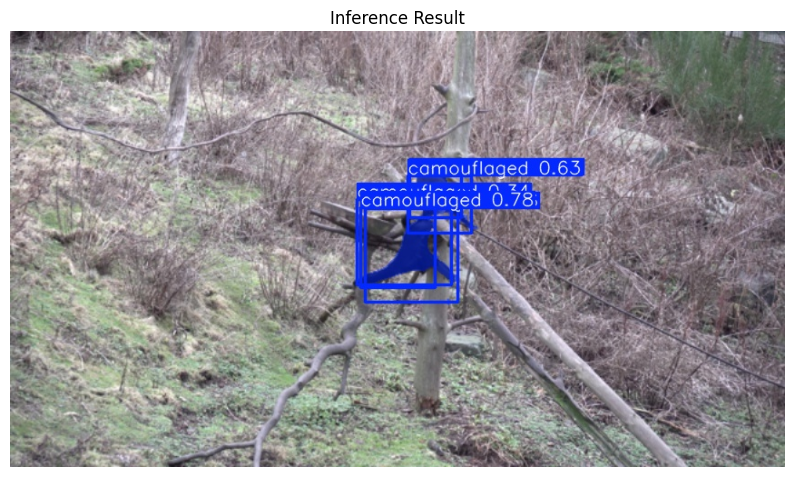

In [ ]:

import matplotlib.pyplot as plt
import cv2
import os
import glob

# The inference results are saved in runs/segment/predict
# Find the latest run directory
predict_dirs = glob.glob('runs/segment/predict*')
predict_dirs.sort(key=os.path.getmtime)
latest_predict_run = predict_dirs[-1] if predict_dirs else None

if latest_predict_run:
    # Find the predicted image in the latest run directory
    # Assuming the image name remains the same as the source image basename
    source_image_basename = os.path.basename('/content/drive/MyDrive/Colab Notebooks/Dataset/CAMO/images/train/camourflage_00401.jpg')
    predicted_image_path = os.path.join(latest_predict_run, source_image_basename)

    if os.path.exists(predicted_image_path):
        img_pred = cv2.imread(predicted_image_path)
        img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(img_pred)
        plt.axis('off')
        plt.title("Inference Result")
        plt.show()
    else:
        print(f"Predicted image not found at {predicted_image_path}")
else:
    print("No prediction run found in runs/segment/")

**Step 13: (Optional) Export Model**

In [ ]:
# Export the best trained segmentation model to ONNX format
!yolo export model=runs/segment/train_epochs_100/weights/best.pt format=onnx

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs

PyTorch: starting from 'runs/segment/train_epochs_100/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 37, 8400), (1, 32, 160, 160)) (6.5 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.64...
ONNX: export success ✅ 1.7s, saved as 'runs/segment/train_epochs_100/weights/best.onnx' (12.7 MB)

Export complete (2.2s)
Results saved to /content/runs/segment/train_epochs_100/weights
Predict:         yolo predict task=segment model=runs/segment/train_epochs_100/weights/best.onnx imgsz=640  
Validate:        yolo val task=segment model=runs/segment/train_epochs_100/weights/best.onnx imgsz=640 data=/content/camo.yaml  
Visualize:       https://netron.app
💡 Learn more at https://docs.ultralytics.com/modes/export


In [ ]:
import tensorflow as tf

gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available.")
    # Further check to see if it's being utilized by a simple operation
    try:
        with tf.device('/GPU:0'):
            a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
            b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
            c = tf.matmul(a, b)
            print("GPU is being utilized for computation.")
            # You can also check device placement
            # tf.debugging.set_log_device_placement(True)
            # tf.matmul(a, b)
    except RuntimeError as e:
        print(f"GPU available but not utilized for computation: {e}")
else:
    print("GPU is not available. Please check your runtime type.")

import torch

if torch.cuda.is_available():
    print("PyTorch reports CUDA is available.")
    # Further check if PyTorch is using the GPU
    device = torch.device("cuda")
    x = torch.randn(5, 5).to(device)
    y = torch.randn(5, 5).to(device)
    z = x + y
    print("PyTorch is utilizing the GPU for computation.")
else:
    print("PyTorch reports CUDA is not available. Please check your runtime type.")

GPU is available.
GPU is being utilized for computation.
PyTorch reports CUDA is available.
PyTorch is utilizing the GPU for computation.


# Task
Generate graphs from the training results of different epochs (10, 50, and 100) located in the folders within "runs/segment/".

## Identify result files

### Subtask:
Locate the `results.csv` or similar metrics files within each of the training run directories in `runs/segment/`.


**Reasoning**:
I need to find the paths to the `results.csv` file in each training run directory within `runs/segment/`. The instructions specify to use the `glob` module to find directories starting with "train_epochs" and then construct the path to `results.csv` within each.



In [ ]:
import glob
import os

# Find all training run directories within runs/segment/ that start with "train_epochs"
train_run_dirs = glob.glob('runs/segment/train_epochs*')

# List to store paths to results.csv files
results_files = []

# For each training run directory, construct the path to results.csv
for run_dir in train_run_dirs:
    results_path = os.path.join(run_dir, 'results.csv')
    if os.path.exists(results_path):
        results_files.append(results_path)

# Print the found paths
print("Found results.csv files:")
for f in results_files:
    print(f)


Found results.csv files:
runs/segment/train_epochs_100/results.csv
runs/segment/train_epochs_10/results.csv
runs/segment/train_epochs_50/results.csv


## Load results

### Subtask:
Read the data from each of the identified result files into pandas DataFrames.


**Reasoning**:
Read the results.csv files into pandas DataFrames and store them in a dictionary.



In [ ]:
import pandas as pd
import os

results_dataframes = {}

for file_path in results_files:
    # Extract the training run name from the directory path
    run_name = os.path.basename(os.path.dirname(file_path))

    # Read the CSV file, skipping lines that start with '#'
    try:
        df = pd.read_csv(file_path, comment='#')
        results_dataframes[run_name] = df
        print(f"Successfully loaded data for: {run_name}")
    except Exception as e:
        print(f"Error loading data for {run_name}: {e}")

# Optional: Print the keys of the dictionary to verify
print("\nLoaded DataFrames for:")
for key in results_dataframes.keys():
    print(key)

# Optional: Display the head of one of the dataframes
if results_dataframes:
    first_key = list(results_dataframes.keys())[0]
    print(f"\nHead of {first_key} DataFrame:")
    display(results_dataframes[first_key].head())

Successfully loaded data for: train_epochs_100
Successfully loaded data for: train_epochs_10
Successfully loaded data for: train_epochs_50

Loaded DataFrames for:
train_epochs_100
train_epochs_10
train_epochs_50

Head of train_epochs_100 DataFrame:


,epoch,time,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),...,metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,21.2864,1.44090,3.41360,2.34012,1.65134,0.36757,0.31022,0.26212,0.09261,...,0.21415,0.17844,0.06176,2.08525,4.63639,2.91308,2.90902,0.000661,0.000661,0.000661
1,2,40.2873,1.68524,3.57144,2.26537,1.85528,0.28010,0.25547,0.17905,0.05469,...,0.22628,0.09622,0.02014,2.33918,5.02691,4.03660,2.96605,0.001315,0.001315,0.001315
2,3,59.0241,1.74399,3.61174,2.22413,1.87625,0.19484,0.31752,0.16024,0.05153,...,0.21898,0.09364,0.02056,2.26574,4.94624,2.97625,2.87361,0.001955,0.001955,0.001955
3,4,77.6799,1.80597,3.77121,2.17919,1.94978,0.28062,0.33577,0.25385,0.09267,...,0.22263,0.16351,0.04634,2.22528,4.59786,2.44829,2.67098,0.001941,0.001941,0.001941
4,5,96.2256,1.75992,3.57839,2.07867,1.88747,0.29931,0.42701,0.30470,0.11647,...,0.26277,0.20804,0.07568,2.18207,4.20858,2.28390,2.62396,0.001921,0.001921,0.001921


## Generate plots

### Subtask:
Create plots (e.g., plots of mAP@0.5, mAP@0.5:0.95, or loss curves over epochs) using the loaded data. You can plot the results from each run on the same graph to compare them.


**Reasoning**:
Create plots to compare the training and validation metrics of the different YOLOv8 segmentation model runs.



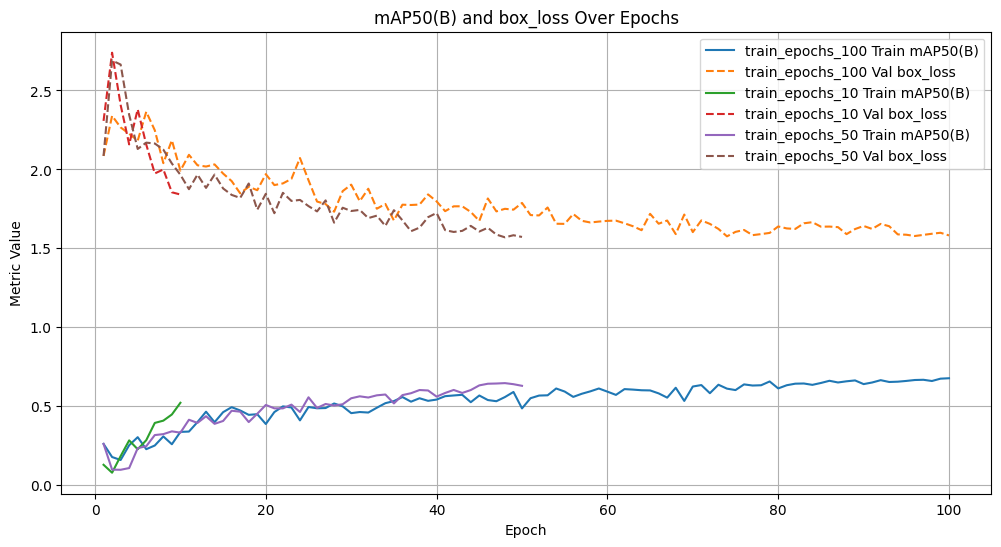

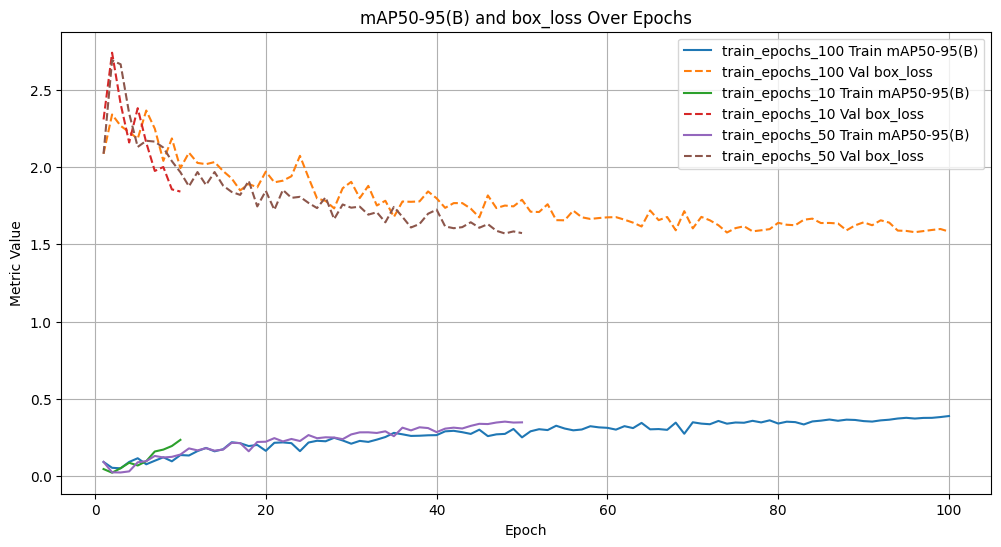

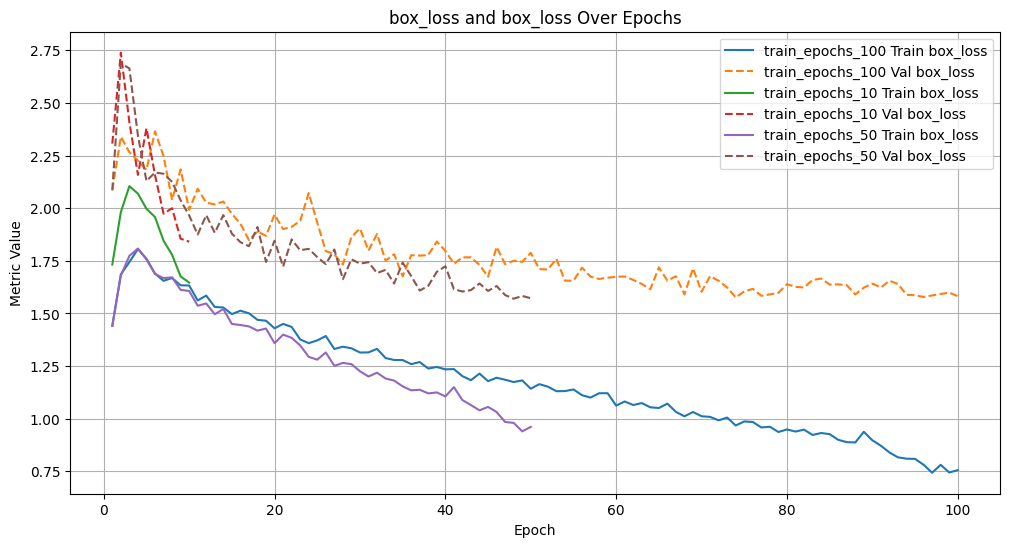

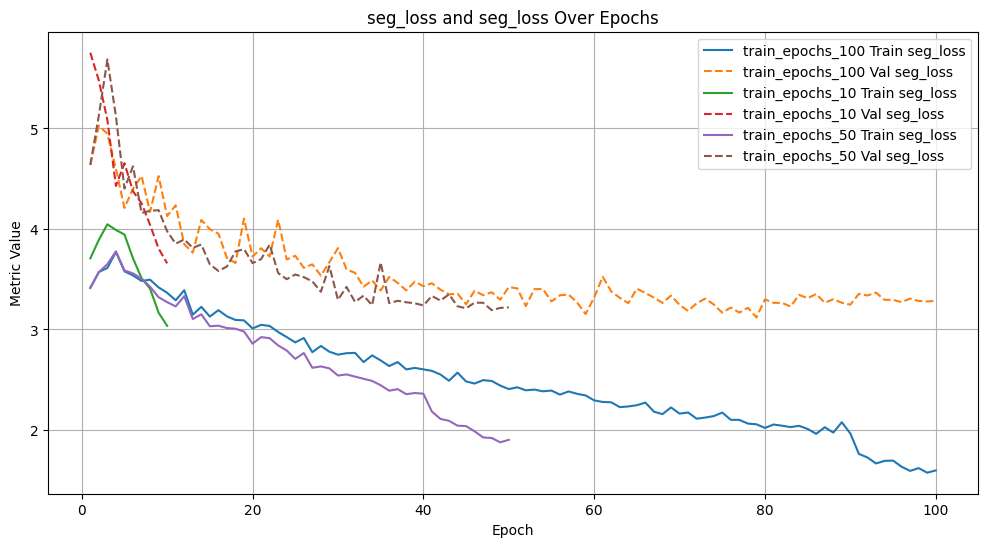

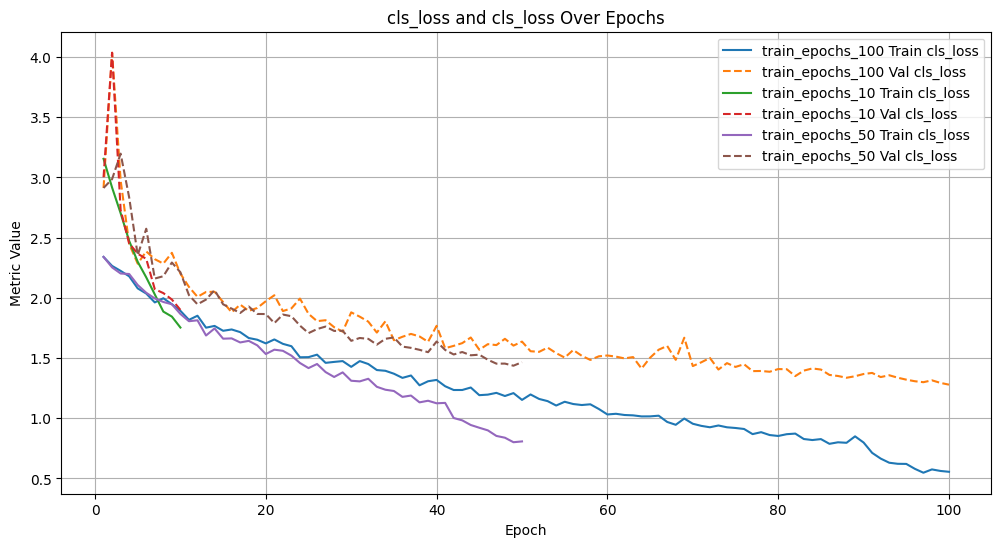

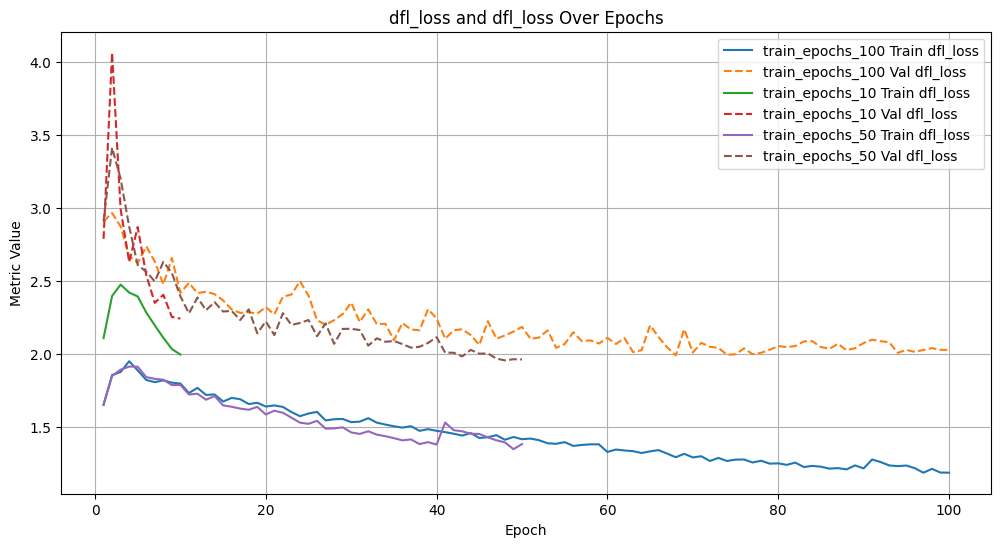

In [ ]:
import matplotlib.pyplot as plt

metrics_to_plot = [
    ('metrics/mAP50(B)', 'val/box_loss'),
    ('metrics/mAP50-95(B)', 'val/box_loss'),
    ('train/box_loss', 'val/box_loss'),
    ('train/seg_loss', 'val/seg_loss'),
    ('train/cls_loss', 'val/cls_loss'),
    ('train/dfl_loss', 'val/dfl_loss')
]

for train_metric, val_metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    for run_name, df in results_dataframes.items():
        if train_metric in df.columns and val_metric in df.columns:
            plt.plot(df['epoch'], df[train_metric], label=f'{run_name} Train {train_metric.split("/")[-1]}')
            plt.plot(df['epoch'], df[val_metric], label=f'{run_name} Val {val_metric.split("/")[-1]}', linestyle='--')
        elif train_metric in df.columns:
             plt.plot(df['epoch'], df[train_metric], label=f'{run_name} Train {train_metric.split("/")[-1]}')
        elif val_metric in df.columns:
             plt.plot(df['epoch'], df[val_metric], label=f'{run_name} Val {val_metric.split("/")[-1]}', linestyle='--')

    plt.title(f"{train_metric.split('/')[-1]} and {val_metric.split('/')[-1]} Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.show()


## Visualize plots

### Subtask:
Visualize plots


## Summary:

### Data Analysis Key Findings

*   The analysis successfully loaded training results from `results.csv` files located in directories corresponding to training runs of 10, 50, and 100 epochs.
*   Plots were generated comparing various metrics (mAP@0.5, mAP@0.5:0.95, box loss, seg loss, cls loss, and dfl loss) for both training and validation sets across the different training runs, allowing for a visual comparison of model performance over different training durations.

### Insights or Next Steps

*   Analyze the generated plots to understand how the number of training epochs impacts model performance and convergence for each metric.
*   Based on the plot analysis, determine if further training (beyond 100 epochs) might lead to better performance or if the models are starting to overfit.
